# Doc2Vec
Train and visualize doc2vec according to [this tutorial](https://humboldt-wi.github.io/blog/research/information_systems_1718/04topicmodels/) using Bundestagsreden.

In [413]:
from plotly import __version__
from plotly import offline as pyoff
from plotly import tools
pyoff.init_notebook_mode(connected=True)

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, plotly.graph_objs as go
import gensim, logging, multiprocessing, os, json, string, re
from nltk.corpus import stopwords
from collections import namedtuple
from nltk.tokenize.casual import TweetTokenizer
from collections import OrderedDict
from datetime import datetime
from sklearn.manifold import TSNE
from time import time

%matplotlib inline

FORMAT = '%(asctime)s %(levelname)s %(message)s'
DATEFORMAT = '%Y-%m-%d %H:%M:%S'
logging.basicConfig(level=logging.INFO,
                    format=FORMAT,
datefmt=DATEFORMAT)

In [75]:
# set working, data and model directories
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
models_dir = os.path.join(parent_dir, 'models')
print('working directory: ', os.getcwd())
print('data directory:    ', data_dir, )
print('models directory:  ', models_dir)

working directory:  /home/tobi/lobby_control/jupyter
data directory:     /home/tobi/lobby_control/data
models directory:   /home/tobi/lobby_control/models


In [76]:
# load data
with open(os.path.join(data_dir, 'bundestag/redner.json'), 'r') as f:
    redner = json.load(f)
with open(os.path.join(data_dir, 'bundestag/reden.json'), 'r') as f:
    reden = json.load(f)

In [214]:
# create dataframe according to tutorial
reden_joined = {key : np.array([redner[key], ' '.join(val)]) for key, val in reden.items() if not key == ''}
data = pd.DataFrame.from_dict(reden_joined).T
data.columns = ['from_name', 'message']
data['Partei_ABK'] = [x.split(', ')[-1] if len(x.split(', ')) > 1 else '' for x in data.from_name]
data.loc[[type(x) != str for x in data.Partei_ABK], 'Partei_ABK'] = '' # might not be necessary, but one time some elements of data.Partei_ABK were empty arrays.
data.from_name = [x.split(', ')[0] if len(x.split(', ')) > 1 else x for x in data.from_name]
# group by name (a few people are duplicated with different IDs)
grouped = data.groupby(['from_name'], as_index=False)
data = grouped.agg({'message' : (lambda x : ' '.join(x)), 'Partei_ABK' : (lambda x : x)})

In [215]:
data.head()

,from_name,message,Partei_ABK
0,Achim Post,Herr Präsident! Liebe Kolleginnen und Kollegen...,SPD
1,Agnieszka Brugger,Herr Präsident! Meine Damen und Herren! Wenige...,BÜNDNIS 90/DIE GRÜNEN
2,Albert Rupprecht,Herr Präsident! Liebe Kolleginnen! Liebe Kolle...,CDU/CSU
3,Albert Stegemann,Sehr geehrter Herr Präsident! Liebe Kolleginne...,CDU/CSU
4,Albrecht Glaser,Herr Präsident! Meine sehr verehrten Damen und...,AfD


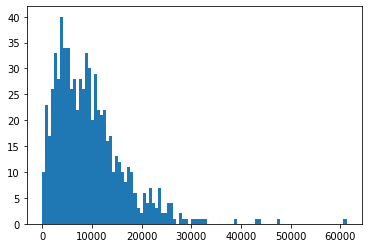

In [216]:
# plot distribution of number of words per politician
a = plt.hist([len(x.split(' ')) for x in data.message], bins=100)

In [217]:
# party names are a quite distinctive pattern, so we remove them beforehand in the messages
for char in ['SPD', 'spd', 'FDP', 'fdp', 'CDU' 'cdu', 'AfD' 'afd', 'AFD', 'Grüne', 'GRÜNE', 'Die Grünen', 'GRÜNEN', 'Linke', 'LINKE', 'CSU', 'csu', 'Die Linke', 'DIE LINKE',]:
    data.message = data.message.str.replace(char, '')

In [218]:
# chunk tokenizes and tags each posts with the candidate’s name
stopword_set = set(stopwords.words('german'))
tokenizer = TweetTokenizer
MessageDoc = namedtuple('MessageDoc', 'words tags')

alldocs = []  # Will hold all doacs in original order
for line_no, line in data.iterrows():
    message = line.message.lower()
    message = tokenizer().tokenize(message) 
    #import pdb; pdb.set_trace()
    words = [word.strip('#') for word in message if (word not in stopword_set 
                                          and word not in string.punctuation
                                          and not word.startswith('http')
                                          and not re.search(r'\d', word))]
    tags = [str(line_no), line['from_name']] #, line['Partei_ABK']] # line_no needs to be converted as string to be included in tags 
    alldocs.append(MessageDoc(words, tags))

In [220]:
# activate fast version of doc2vec
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1

In [221]:
# set model parameters
models = [
    gensim.models.Doc2Vec(dm=0, dbow_words=0, vector_size=100, negative=5, hs=0, min_count=5, workers=cores),
    gensim.models.Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=10, negative=5, hs=0, min_count=5, workers=cores),
]

In [222]:
# build the vocabulary and transfer it to all models
# speed up setup by sharing results of the 1st model's vocabulary scan
models[0].build_vocab(alldocs)  # PV-DM w/ concat requires one special NULL word so it serves as template
print(models[0])
for model in models[1:]:
    model.reset_from(models[0])
print(model)

2019-11-10 20:50:38 INFO collecting all words and their counts
2019-11-10 20:50:38 INFO PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2019-11-10 20:50:38 INFO collected 144944 word types and 1456 unique tags from a corpus of 728 examples and 3420565 words
2019-11-10 20:50:38 INFO Loading a fresh vocabulary
2019-11-10 20:50:39 INFO effective_min_count=5 retains 37609 unique words (25% of original 144944, drops 107335)
2019-11-10 20:50:39 INFO effective_min_count=5 leaves 3254626 word corpus (95% of original 3420565, drops 165939)
2019-11-10 20:50:39 INFO deleting the raw counts dictionary of 144944 items
2019-11-10 20:50:39 INFO sample=0.001 downsamples 29 most-common words
2019-11-10 20:50:39 INFO downsampling leaves estimated 3119997 word corpus (95.9% of prior 3254626)
2019-11-10 20:50:39 INFO estimated required memory for 37609 words and 100 dimensions: 49765300 bytes
2019-11-10 20:50:39 INFO resetting layer weights
2019-11-10 20:50:39 INFO resetting layer w

Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)
Doc2Vec(dm/m,d100,n5,w10,mc5,s0.001,t4)


In [223]:
# to be able to call the models by their name we use an ordered dictionary
models_by_name = OrderedDict((str(model), model) for model in models[0:])

In [226]:
%%time
# train the models (~ 13 min)
epochs = 50
for name, train_model in models_by_name.items():
    train_model.train(alldocs, total_examples=len(alldocs), epochs=epochs, start_alpha=0.025, end_alpha=0.001)

In [227]:
# save the models
count = 1
for name, trained_model in models_by_name.items():
    #import pdb; pdb.set_trace()
    name = name.replace('/', '')
    if count>len(models):
        break
    else:
        trained_model.save(os.path.join(models_dir, name + '_e' + str(epochs) + '.model'))
count += 1

2019-11-10 21:03:37 INFO saving Doc2Vec object under /home/tobi/lobby_control/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e50.model, separately None
2019-11-10 21:03:37 INFO saved /home/tobi/lobby_control/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e50.model
2019-11-10 21:03:37 INFO saving Doc2Vec object under /home/tobi/lobby_control/models/Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e50.model, separately None
2019-11-10 21:03:37 INFO saved /home/tobi/lobby_control/models/Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e50.model


In [396]:
candidate_data = data.loc[:,['from_name', 'Partei_ABK']]

party_colors = {'AfD': 'rgb(0, 0, 153)',
                'DIE LINKE': 'rgb(204, 0, 102)',
                'BÜNDNIS 90/DIE GRÜNEN': 'rgb(0, 153, 0)',
                'CDU/CSU' : 'rgb(0, 0, 0)',
                'FDP': 'rgb(255, 255, 51)',
                'SPD': 'rgb(255, 0, 0)',
                'fraktionslos' : 'rgb(200, 200, 200)',
                '' : 'rgb(200, 200, 200)'}

candidate_data['color'] = candidate_data['Partei_ABK'].map(party_colors)

party_colors = {'AfD': 'xkcd:blue',
                'DIE LINKE': 'xkcd:magenta',
                'BÜNDNIS 90/DIE GRÜNEN': 'xkcd:grass green',
                'CDU/CSU': 'xkcd:black',
                'FDP': 'xkcd:goldenrod',
                'SPD': 'xkcd:red',
                'fraktionslos' : 'xkcd:grey',
                '' : 'xkcd:grey'}
candidate_data['color2'] = candidate_data['Partei_ABK'].map(party_colors)

leaders = ['Sahra Wagenknecht',
'Dietmar Bartsch',
'Katrin Göring-Eckardt',
'Cem Özdemir',
'Martin Schulz',
'Angela Merkel',
'Joachim Herrmann',
'Alexander Gauland',
'Alice Weidel']

candidate_data['leader'] = data['from_name'].isin(leaders)

candidate_data['size'] = 5
candidate_data.loc[candidate_data['from_name'].str.contains('Party'),'size'] = 10
candidate_data.loc[candidate_data['leader'], 'size'] = 8

candidate_data['symbol'] = 100
candidate_data.loc[candidate_data['from_name'].str.contains('Party'), 'symbol'] = 101
candidate_data.loc[candidate_data['leader'], 'symbol'] = 114

candidate_data['symbol2'] = '.'
candidate_data.loc[candidate_data['from_name'].str.contains('Party'), 'symbol2'] = 's'
candidate_data.loc[candidate_data['leader'], 'symbol2'] = 'h'

In [314]:
model7_name = 'Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e50.model'
model8_name = 'Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e50.model'

model7 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model7_name))
model8 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model8_name))

2019-11-10 21:24:36 INFO loading Doc2Vec object from /home/tobi/lobby_control/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e50.model
2019-11-10 21:24:37 INFO loading vocabulary recursively from /home/tobi/lobby_control/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e50.model.vocabulary.* with mmap=None
2019-11-10 21:24:37 INFO loading trainables recursively from /home/tobi/lobby_control/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e50.model.trainables.* with mmap=None
2019-11-10 21:24:37 INFO loading wv recursively from /home/tobi/lobby_control/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e50.model.wv.* with mmap=None
2019-11-10 21:24:37 INFO loading docvecs recursively from /home/tobi/lobby_control/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e50.model.docvecs.* with mmap=None
2019-11-10 21:24:37 INFO loaded /home/tobi/lobby_control/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e50.model
2019-11-10 21:24:37 INFO loading Doc2Vec object from /home/tobi/lobby_control/models/Doc2Vec(dmm,d100,n5,w10,mc5,

In [376]:
%%time
# creates subplot
fig4 = tools.make_subplots(rows=1, cols=2, subplot_titles=[model7_name, model8_name])

# vectors for model seven
mask = [tag in candidate_data['from_name'].values for tag in model7.docvecs.offset2doctag]
candidate_vecs = model7.docvecs.doctag_syn0[mask]

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne7 = tsne.fit_transform(X)

# vectors for model eight
mask = [tag in candidate_data['from_name'].values for tag in model8.docvecs.offset2doctag]
candidate_vecs = model8.docvecs.doctag_syn0[mask]

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne8 = tsne.fit_transform(X)

# creates scatter plot and appends it to the subplot figure 4
trace = go.Scatter(x=X_tsne7[:, 0], y=X_tsne7[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
fig4.append_trace(trace, 1, 1)

trace = go.Scatter(x=X_tsne8[:, 0], y=X_tsne8[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
fig4.append_trace(trace, 1, 2)

# updates the title of the subplot
fig4['layout'].update(title='Models with epochs=20', showlegend=False)

/home/tobi/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/home/tobi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).

/home/tobi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning:

Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).



CPU times: user 18.5 s, sys: 144 ms, total: 18.7 s
Wall time: 18.3 s


Layout({
    'annotations': [{'font': {'size': 16},
                     'showarrow': False,
                     'text': 'Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e50.model',
                     'x': 0.225,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'},
                    {'font': {'size': 16},
                     'showarrow': False,
                     'text': 'Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e50.model',
                     'x': 0.775,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'}],
    'showlegend': False,
    'template': '...',
    'title': {'text': 'Models with epochs=20'},
    'xaxis': {'anchor': 'y', 'domain': [0.0, 0.45]},
    'xaxis2': {'anchor': 'y2', 'domain': [0.55, 1.0]},
    'yaxi

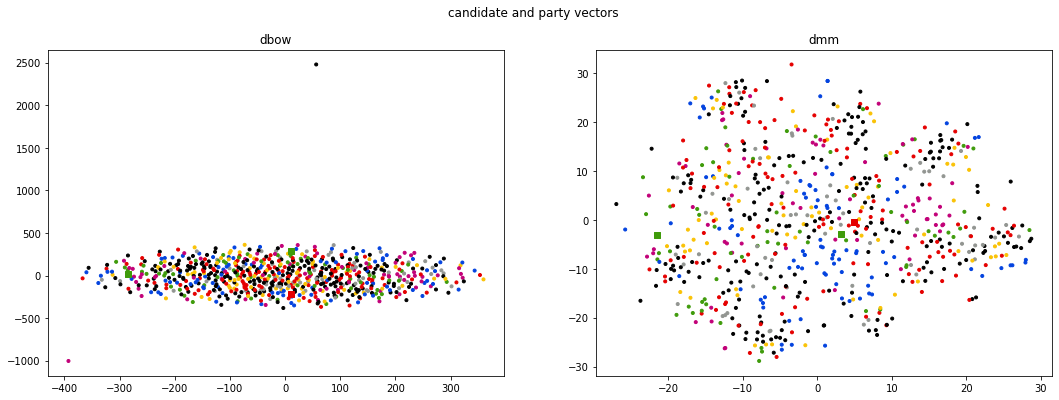

In [419]:
#shows plotly graph
#pyoff.iplot(fig4, filename='tsnePlot1_epochs20')

f4, axes = plt.subplots(1, 2, sharey=False, figsize=(18,6))

# creates markers for matplotlib
markers = [".", "s", "h"]

for i, c in enumerate(np.unique(candidate_data['symbol2'])):
    axes[0].scatter(X_tsne7[:,0][candidate_data['symbol2']==c], X_tsne7[:, 1][candidate_data['symbol2']==c], c=candidate_data['color2'][candidate_data['symbol2']==c], marker=markers[i])
    axes[0].set_title('dbow')
    
for i, c in enumerate(np.unique(candidate_data['symbol2'])):
    axes[1].scatter(X_tsne8[:,0][candidate_data['symbol2']==c], X_tsne8[:, 1][candidate_data['symbol2']==c], c=candidate_data['color2'][candidate_data['symbol2']==c], marker=markers[i])
    axes[1].set_title('dmm')

f4.suptitle('candidate and party vectors')

# f4.show()
f4.savefig('tsne_50.pdf', format='pdf', orientation='landscape')